In [1]:
# This notebook is for functional parcellation using HCPMMP cortical parcellation matrix and spectral clustering.

# Includes:
#     Connectivity matrix
#     Clustering
#     Internal Index
#     Cortical Projection
#     Network associated to cortical projection

In [2]:
import os
from numpy import load
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
from sklearn.cluster import SpectralClustering
import sklearn
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import SpectralClustering
from sklearn.metrics import davies_bouldin_score
from brainspace.datasets import load_fsa5
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_parcellation
from brainspace.utils.parcellation import map_to_labels
from neuromaps import images
from nilearn import plotting
import plotly.express as px
import plotly.graph_objects as go

### Setting the path

In [3]:
main_path = "/srv/khan/users/sudesnac/"
#main_path = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/"

In [4]:
# get the current notebook path
note_path = main_path + "HumanBF-Parcellation/notebook/"
data_path = main_path + "HumanBF-Parcellation/data/"
results_path = main_path + "HumanBF-Parcellation/results/Func_HCPMMP/"
fig_path = main_path + "HumanBF-Parcellation/results/figures/Func_HCPMMP/"

### Checking the connectivity matrix

In [5]:
# load npz data
data = load(data_path + 'correlation_matrix_HCP-MMP_group.npz')
correlation = data['corr_group']
indices = data['indices']

In [6]:
# Average correlation matrix
corr_avg = np.nanmean(correlation,axis=0)
corr_avg += 1
corr_avg[np.isnan(corr_avg)] = 1

In [7]:
# Reshape and concatenate subjects
corr = np.moveaxis(correlation,0,2)
corr_concat = corr.reshape([corr.shape[0],corr.shape[1]*corr.shape[2]])
corr_concat += 1 # Spectral clustering doesn't like negative input apparantly, or square
corr_concat[np.isnan(corr_concat)] = 1

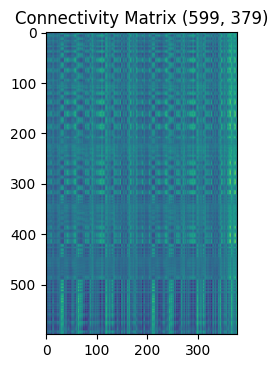

In [8]:
# Plot this matrix.
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(corr_avg)
ax.set_title('Connectivity Matrix {}'.format(corr_avg.shape))
plt.show()

### Spectral clustering

In [9]:
# Function to save niftis
def save_label_nii (labelimg,affine,header,out_nifti):
    img = nib.Nifti1Image(labelimg,affine=affine,header=header)
    nib.save(img,out_nifti)

# get seed data
afile = (data_path + 'seed-BASF_HCP-MMP_BigBrain1p6mm_59k.nii.gz')
atlas = nib.load(afile)
atlas_data = atlas.get_fdata()
    
# Output
max_k = 4
cluster_range = range(2,max_k+1)
cluster = list(cluster_range)
out_nii_list =[results_path + f'Func_HCPMMP_method-spectralcosine_k-'+ cluster +'_cluslabels.nii.gz' for cluster in[str(int) for int in cluster]]
labels = np.zeros((corr_concat.shape[0],len(cluster_range)))

# Run spectral clustering and save results to nifti
for i,k in enumerate(cluster_range):
    clustering = SpectralClustering(n_clusters=k, assign_labels="discretize",random_state=0,affinity='cosine').fit(corr_concat)
    labels[:,i] = clustering.labels_
    
    labelimg = np.zeros(atlas_data.shape)
    for j in range(0,len(atlas_data[atlas_data==16])):
        labelimg[indices[j][0],indices[j][1],indices[j][2]] = labels[j,i]+1
    
    print(f'i={i},k={k},saving {out_nii_list[i]}')
    save_label_nii(labelimg,atlas.affine,atlas.header,out_nii_list[i])

# Save results to CSV file
df = pd.DataFrame(labels,columns=cluster_range)
df.to_csv(results_path + 'Func_HCPMMP_clusterlabels_seed-BASF_1p6mm.csv')

i=0,k=2,saving /srv/khan/users/sudesnac/HumanBF-Parcellation/results/Func_HCPMMP/Func_HCPMMP_method-spectralcosine_k-2_cluslabels.nii.gz
i=1,k=3,saving /srv/khan/users/sudesnac/HumanBF-Parcellation/results/Func_HCPMMP/Func_HCPMMP_method-spectralcosine_k-3_cluslabels.nii.gz
i=2,k=4,saving /srv/khan/users/sudesnac/HumanBF-Parcellation/results/Func_HCPMMP/Func_HCPMMP_method-spectralcosine_k-4_cluslabels.nii.gz


### Internal Index

In [15]:
spectral_model = {}
cluster_range = range(2,20)

# Concat data clustering
HCPcc_sil_scores = []
HCPcc_chi_scores = []
HCPcc_dbi_scores = []

for k in cluster_range:
    spectral_model[k] = SpectralClustering(n_clusters=k, assign_labels="discretize",random_state=0,affinity='cosine').fit(corr_concat)
    HCPcc_labels = spectral_model[k].labels_
    HCPcc_sil_scores.append(sklearn.metrics.silhouette_score(corr_concat, HCPcc_labels, metric='cosine'))
    HCPcc_chi_scores.append(sklearn.metrics.calinski_harabasz_score(corr_concat, HCPcc_labels))
    HCPcc_dbi_scores.append(davies_bouldin_score(corr_concat, HCPcc_labels))

# Average data clustering
HCPav_sil_scores = []
HCPav_chi_scores = []
HCPav_dbi_scores = []

for k in cluster_range:
    spectral_model[k] = SpectralClustering(n_clusters=k, assign_labels="discretize",random_state=0,affinity='cosine').fit(corr_avg)
    HCPav_labels = spectral_model[k].labels_
    HCPav_sil_scores.append(sklearn.metrics.silhouette_score(corr_avg, HCPav_labels, metric='cosine'))
    HCPav_chi_scores.append(sklearn.metrics.calinski_harabasz_score(corr_avg, HCPav_labels))
    HCPav_dbi_scores.append(davies_bouldin_score(corr_avg, HCPav_labels))

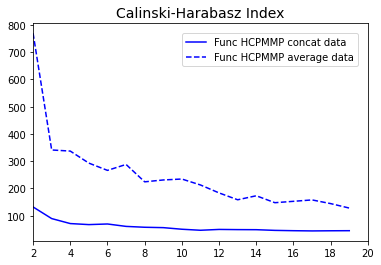

In [16]:
plt.gca().set_prop_cycle(color=['b','b'],linestyle=['-','--'])

plt.plot(cluster_range, HCPcc_chi_scores, label="Func HCPMMP concat data")
plt.plot(cluster_range, HCPav_chi_scores, label="Func HCPMMP average data")

plt.xlim(2,20)
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=10)
plt.title('Calinski-Harabasz Index', fontsize=14)
plt.savefig(fig_path + f'Func_HCPMMP_Calinski-Harabasz_Index.png')
plt.show()

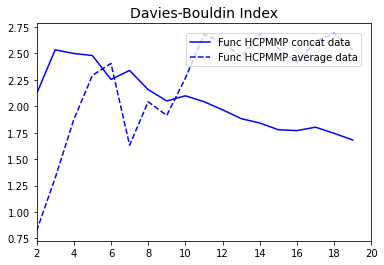

In [17]:
plt.gca().set_prop_cycle(color=['b','b'],linestyle=['-','--'])

plt.plot(cluster_range, HCPcc_dbi_scores, label="Func HCPMMP concat data")
plt.plot(cluster_range, HCPav_dbi_scores, label="Func HCPMMP average data")

plt.xlim(2,20)
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=10)
plt.title('Davies-Bouldin Index', fontsize=14)
plt.savefig(fig_path + f'Func_HCPMMP_Davies-Bouldin_Index.png')
plt.show()

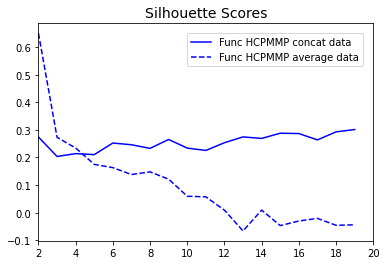

In [18]:
plt.gca().set_prop_cycle(color=['b','b'],linestyle=['-','--'])

plt.plot(cluster_range, HCPcc_sil_scores, label="Func HCPMMP concat data")
plt.plot(cluster_range, HCPav_sil_scores, label="Func HCPMMP average data")

plt.xlim(2,20)
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=10)
plt.title('Silhouette Scores', fontsize=14)
plt.savefig(fig_path + f'Func_HCPMMP_Silhouette_Scores.png')
plt.show()

### Visualize chosen k-3 cluster solution

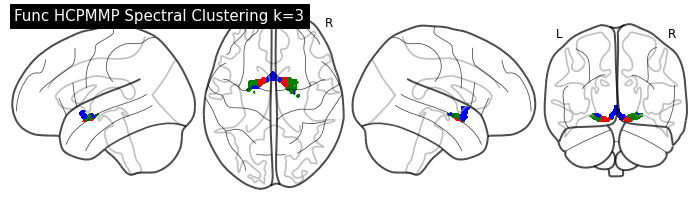

In [20]:
file = (results_path+'Func_HCPMMP_method-spectralcosine_k-3_cluslabels.nii.gz')
cluster = nib.load(file)
from matplotlib.colors import ListedColormap
colors = ListedColormap(['red', 'green', 'blue'])
display = plotting.plot_glass_brain(None, display_mode='lzry', colorbar=True)
display.add_contours(cluster, filled=True, cmap=colors)
display.title('Func HCPMMP Spectral Clustering k=3')
display.savefig(fig_path + 'Func_HCPMMP_method-spectralcosine_k-3_cluslabels.png')

### Cortical Projection

In [21]:
# Reading saved spetral clustering results file
clusterlabels_df = pd.read_csv(results_path + 'Func_HCPMMP_clusterlabels_seed-BASF_1p6mm.csv')
clusterlabels = clusterlabels_df.to_numpy()
k3_labels = clusterlabels[:,2]

In [22]:
cluster1_mat = corr_concat[k3_labels == 0]
cluster2_mat = corr_concat[k3_labels == 1]
cluster3_mat = corr_concat[k3_labels == 2]
cluster1_corr = np.reshape(cluster1_mat, (len(cluster1_mat[:,0]), 379, 173))
cluster2_corr = np.reshape(cluster2_mat, (len(cluster2_mat[:,0]), 379, 173)) 
cluster3_corr = np.reshape(cluster3_mat, (len(cluster3_mat[:,0]), 379, 173))
cluster1_corrFC = cluster1_corr[:,:-19,:]
cluster2_corrFC = cluster2_corr[:,:-19,:]
cluster3_corrFC = cluster3_corr[:,:-19,:]
clust1_avg = np.nanmean(cluster1_corrFC,axis=2)
clust2_avg = np.nanmean(cluster2_corrFC,axis=2)
clust3_avg = np.nanmean(cluster3_corrFC,axis=2)

In [23]:
pd.DataFrame(clust1_avg).to_csv(results_path + 'Func_HCPMMP_k3-cluster1_avg.csv', index=False)
pd.DataFrame(clust2_avg).to_csv(results_path + 'Func_HCPMMP_k3-cluster2_avg.csv', index=False)
pd.DataFrame(clust3_avg).to_csv(results_path + 'Func_HCPMMP_k3-cluster3_avg.csv', index=False)

In [24]:
clust1_ctx = np.nanmean(clust1_avg,axis=0).reshape([360,1])
clust2_ctx = np.nanmean(clust2_avg,axis=0).reshape([360,1])
clust3_ctx = np.nanmean(clust3_avg,axis=0).reshape([360,1])

In [25]:
# setting up for cortical projection using brainspace
surf_lh, surf_rh = load_fsa5()

surf_labels_lh = nib.freesurfer.read_annot(data_path + 'lh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh = nib.freesurfer.read_annot(data_path + 'rh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh[surf_labels_rh != 0] += 180  # different labels for lh and rh
surf_labels = np.concatenate([surf_labels_lh, surf_labels_rh])

mask = surf_labels != 0  # discard medial wall

In [26]:
k3clust1 = map_to_labels(clust1_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)
k3clust2 = map_to_labels(clust2_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)
k3clust3 = map_to_labels(clust3_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)

In [27]:
# Plot on the surface and save as png file
plot_hemispheres(surf_lh, surf_rh, array_name=[k3clust1], label_text=['k-3 cluster1'],
    size=(800, 200),  cmap=['Reds'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Func_HCPMMP_k-3_cluster-1_Cortex.png')

'/srv/khan/users/sudesnac/HumanBF-Parcellation/results/figures/Func_HCPMMP/Func_HCPMMP_k-3_cluster-1_Cortex.png'

In [28]:
plot_hemispheres(surf_lh, surf_rh, array_name=[k3clust2], label_text=['k-3 cluster2'],
    size=(800, 200),  cmap=['Greens'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Func_HCPMMP_k-3_cluster-2_Cortex.png')

'/srv/khan/users/sudesnac/HumanBF-Parcellation/results/figures/Func_HCPMMP/Func_HCPMMP_k-3_cluster-2_Cortex.png'

In [29]:
plot_hemispheres(surf_lh, surf_rh, array_name=[k3clust3], label_text=['k-3 cluster3'],
    size=(800, 200),  cmap=['Blues'], color_bar=True, embed_nb=True, screenshot=True, filename=fig_path+'Func_HCPMMP_k-3_cluster-3_Cortex.png')

'/srv/khan/users/sudesnac/HumanBF-Parcellation/results/figures/Func_HCPMMP/Func_HCPMMP_k-3_cluster-3_Cortex.png'

In [30]:
# Save the cortical projection as gii files
k3_clusters = [k3clust1, k3clust2, k3clust3]

for c in range(0, len(k3_clusters)):
    gii_L = nib.gifti.GiftiImage()
    gii_L.add_gifti_data_array(
        nib.gifti.GiftiDataArray(k3_clusters[c][:32492].astype(np.float32))) # For left hemisphere
    nib.save(gii_L, results_path+'Func_HCPMMP_k-3_cluster-'+str(c+1)+'_L_fsa-10k.gii')

for c in range(0, len(k3_clusters)):
    gii_R = nib.gifti.GiftiImage()
    gii_R.add_gifti_data_array(
        nib.gifti.GiftiDataArray(k3_clusters[c][32492:].astype(np.float32))) # right hemisphere is [32492:]
    nib.save(gii_R, results_path+'Func_HCPMMP_k-3_cluster-'+str(c+1)+'_R_fsa-10k.gii')

### Visualize Cortical Projection

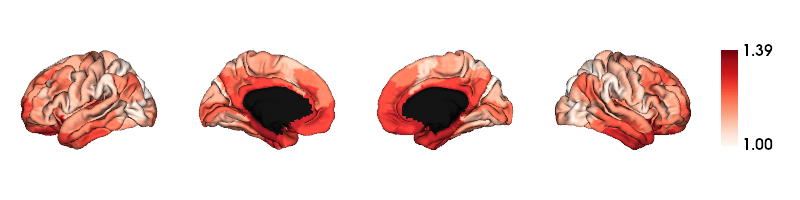

In [31]:
# For checking the saved cortical projection gii files
Sch_k3clust_L = images.load_gifti(results_path+'Func_HCPMMP_k-3_cluster-1_L_fsa-10k.gii')
Sch_k3clust_R = images.load_gifti(results_path+'Func_HCPMMP_k-3_cluster-1_R_fsa-10k.gii')
Sch_k3clust_L_data = Sch_k3clust_L.agg_data()
Sch_k3clust_R_data = Sch_k3clust_R.agg_data()
Sch_k3clust_data = np.concatenate((Sch_k3clust_L_data, Sch_k3clust_R_data))

surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[Sch_k3clust_data], size=(800, 200), cmap=['Reds'], color_bar=True, embed_nb=True)

### Network associated with Cortical projection

In [32]:
labels_txt = pd.read_csv(data_path+'hcp_mmp10_yeo7_modes.txt',header=None)

In [33]:
labels_txt[['Label','Hemisphere','Area','ROI','Network#','Network']]= labels_txt[0].str.split('_',expand=True)
networks = labels_txt['Network'].unique()

In [34]:
clust1_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = clust1_avg[:,net_inds]
        net_mean.append(net_con_df.mean())

clust1_matrix.append(net_mean)

In [35]:
clust2_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = clust2_avg[:,net_inds]
        net_mean.append(net_con_df.mean())

clust2_matrix.append(net_mean)

In [36]:
clust3_matrix = []
net_mean = []
for nets in networks:
        net_df = labels_txt.loc[(labels_txt['Network'] == nets)]
        net_inds = list(net_df.index.values)
        net_con_df = clust3_avg[:,net_inds]
        net_mean.append(net_con_df.mean())

clust3_matrix.append(net_mean)

In [37]:
clust1_array = np.array(clust1_matrix)
clust2_array = np.array(clust2_matrix)
clust3_array = np.array(clust3_matrix)

In [38]:
cluster_network_df = pd.DataFrame({'networks':networks, 'clust1':clust1_array.reshape([7]), 'clust2':clust2_array.reshape([7]), 'clust3':clust3_array.reshape([7])})
pd.DataFrame(cluster_network_df).to_csv(results_path + 'Func_HCPMMP_k3-cluster_network.csv', index=False)

In [10]:
cluster_network_df = pd.read_csv(results_path + 'Func_HCPMMP_k3-cluster_network.csv')
cluster_network_df

networks    clust1    clust2    clust3
0             Visual  1.112483  1.142056  1.080884
1        Somatomotor  1.157429  1.215525  1.134924
2   Dorsal Attention  1.091599  1.197324  0.998851
3  Ventral Attention  1.123548  1.300244  0.999946
4            Default  1.216435  1.106560  1.247885
5     Frontoparietal  1.171531  1.188446  1.075770
6             Limbic  1.302602  1.243477  1.294780

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/plotly/express/_core.py:271: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trace_data = trace_data.append(trace_data.iloc[0])


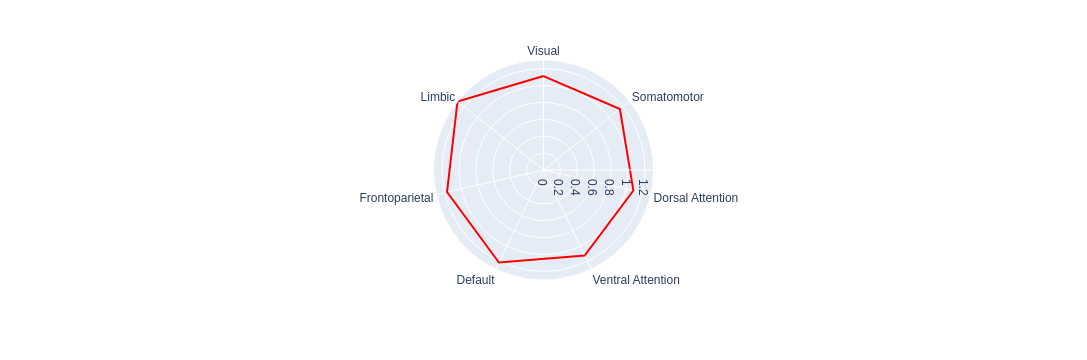

In [40]:
# Checking individual cluster network
fig = px.line_polar(cluster_network_df, r='clust1', theta='networks', color_discrete_sequence=['red'], line_close=True)
fig.show()

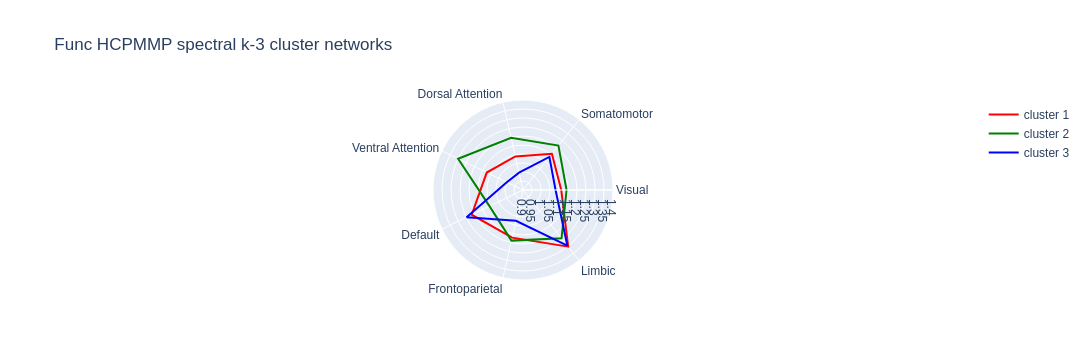

In [11]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=cluster_network_df['clust1'].values.tolist() + cluster_network_df['clust1'].values.tolist()[:1], theta=cluster_network_df['networks'].tolist() + cluster_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'red', name='cluster 1'))
fig.add_trace(go.Scatterpolar(r=cluster_network_df['clust2'].values.tolist() + cluster_network_df['clust2'].values.tolist()[:1], theta=cluster_network_df['networks'].tolist() + cluster_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'green', name='cluster 2'))
fig.add_trace(go.Scatterpolar(r=cluster_network_df['clust3'].values.tolist() + cluster_network_df['clust3'].values.tolist()[:1], theta=cluster_network_df['networks'].tolist() + cluster_network_df['networks'].tolist()[:1], mode = 'lines', line_color = 'blue', name='cluster 3'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0.9, 1.4])),title = 'k-3 clsuter networks', showlegend=True)

fig.update_layout(title = 'Func HCPMMP spectral k-3 cluster networks', showlegend=True)
fig.show()
fig.write_image(fig_path+'Func_HCPMMP_spectral_k-3_cluster_networks.png')